<a href="https://colab.research.google.com/github/Shufen-Yin/Artificial-Intelligence/blob/main/ML_Assignment_8_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 8: Continual Learning and Test in Production

In [5]:
# 1 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torchvision
import torchvision.transforms as transforms

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [6]:
# 2 — Load CIFAR-10 and convert to numpy arrays
transform = transforms.Compose([transforms.ToTensor()])  # We'll convert to numpy later

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Convert to numpy arrays (images as HxWxC, values in [0,1])
def dataset_to_arrays(dataset):
    X = []
    y = []
    for img, label in dataset:
        arr = img.numpy().transpose(1,2,0)  # C,H,W -> H,W,C
        X.append(arr)
        y.append(label)
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.int32)
    return X, y

X_train_all, y_train_all = dataset_to_arrays(trainset)
X_test_all, y_test_all = dataset_to_arrays(testset)

print("Train shape:", X_train_all.shape, "Train labels:", y_train_all.shape)
print("Test shape:", X_test_all.shape, "Test labels:", y_test_all.shape)


Train shape: (50000, 32, 32, 3) Train labels: (50000,)
Test shape: (10000, 32, 32, 3) Test labels: (10000,)


In [7]:
#3 — Build Subset A (classes 0-4) and Subset B (classes 5-9)
# We'll ensure each subset is balanced per class (take min available per class)
def build_balanced_subset(X, y, classes, per_class=None, seed=42):
    idxs = []
    for c in classes:
        c_idx = np.where(y == c)[0]
        if per_class is None:
            per_class = min(len(np.where(y==cl)[0]) for cl in classes)
        chosen = np.random.choice(c_idx, per_class, replace=False)
        idxs.extend(chosen.tolist())
    idxs = np.array(idxs)
    return X[idxs], y[idxs]

classes_A = list(range(0,5))
classes_B = list(range(5,10))

# Choose a per-class sample count - CIFAR has 5000 per class in train, we can choose 500 per class to keep compute small
per_class = 500

X_A, y_A = build_balanced_subset(X_train_all, y_train_all, classes_A, per_class=per_class)
X_B, y_B = build_balanced_subset(X_train_all, y_train_all, classes_B, per_class=per_class)

print("Subset A:", X_A.shape, y_A.shape, "labels:", np.unique(y_A, return_counts=True))
print("Subset B:", X_B.shape, y_B.shape, "labels:", np.unique(y_B, return_counts=True))


Subset A: (2500, 32, 32, 3) (2500,) labels: (array([0, 1, 2, 3, 4], dtype=int32), array([500, 500, 500, 500, 500]))
Subset B: (2500, 32, 32, 3) (2500,) labels: (array([5, 6, 7, 8, 9], dtype=int32), array([500, 500, 500, 500, 500]))


In [8]:
# 4 — Preprocessing: flatten images into vectors and scale
def flatten_and_scale(X_train, X_val=None):
    n = X_train.shape[0]
    flat_train = X_train.reshape(n, -1)  # each row is 32*32*3 = 3072
    scaler = StandardScaler()
    flat_train = scaler.fit_transform(flat_train)
    if X_val is not None:
        flat_val = X_val.reshape(X_val.shape[0], -1)
        flat_val = scaler.transform(flat_val)
        return flat_train, flat_val, scaler
    return flat_train, scaler

# We'll create train/val splits for Subset A
X_A_flat, X_A_val, y_A_train, y_A_val = None, None, None, None
X_A_train_index, X_A_val_index = train_test_split(np.arange(len(X_A)), test_size=0.2, random_state=42, stratify=y_A)
X_A_train = X_A[X_A_train_index]; y_A_train = y_A[X_A_train_index]
X_A_val   = X_A[X_A_val_index];   y_A_val   = y_A[X_A_val_index]

X_A_flat_train, X_A_flat_val, scaler = flatten_and_scale(X_A_train, X_A_val)
# For Subset B we will transform with same scaler when needed
X_B_flat = X_B.reshape(len(X_B), -1)
X_B_flat = scaler.transform(X_B_flat)


In [9]:
#5 — Helper: evaluation reporting (accuracy + confusion matrix)
def evaluate_model(model, X, y, classes=None, verbose=True):
    preds = model.predict(X)
    acc = accuracy_score(y, preds)
    if verbose:
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y, preds, digits=4))
    cm = confusion_matrix(y, preds, labels=classes)
    return acc, cm, preds


In [11]:
# 6 — Train initial SGDClassifier on Subset A (classes 0-4)
# We'll use logistic loss (logistic regression via SGD), early stopping via max_iter and tol
model_init = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42, verbose=0)

# For partial_fit compatibility later, supply classes param that includes all eventual classes (0-9)
all_classes = np.arange(0,10)

# We can first fit on A_train (since pure batch fit is fine)
model_init.fit(X_A_flat_train, y_A_train)
print("Initial model trained on Subset A.")
acc_A_val, cm_A_val, _ = evaluate_model(model_init, X_A_flat_val, y_A_val, classes=classes_A, verbose=True)


Initial model trained on Subset A.
Accuracy: 0.4620
              precision    recall  f1-score   support

           0     0.5652    0.3900    0.4615       100
           1     0.7164    0.4800    0.5749       100
           2     0.3492    0.4400    0.3894       100
           3     0.4143    0.5800    0.4833       100
           4     0.4286    0.4200    0.4242       100

    accuracy                         0.4620       500
   macro avg     0.4947    0.4620    0.4667       500
weighted avg     0.4947    0.4620    0.4667       500



In [12]:
#7 — Evaluate initial model on Subset B (out-of-distribution classes 5-9)
# Important: the initial model was trained on labels 0-4; predicting on labels 5-9 will produce some predictions in 0-4
# For fair measurement, we compute accuracy by whether model predicts the correct label (it won't)
acc_on_B, cm_on_B, preds_B = evaluate_model(model_init, X_B_flat, y_B, classes=classes_B, verbose=True)
print("Initial model accuracy on Subset B (novel classes):", acc_on_B)


Accuracy: 0.0000
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       0.0
           1     0.0000    0.0000    0.0000       0.0
           2     0.0000    0.0000    0.0000       0.0
           3     0.0000    0.0000    0.0000       0.0
           4     0.0000    0.0000    0.0000       0.0
           5     0.0000    0.0000    0.0000     500.0
           6     0.0000    0.0000    0.0000     500.0
           7     0.0000    0.0000    0.0000     500.0
           8     0.0000    0.0000    0.0000     500.0
           9     0.0000    0.0000    0.0000     500.0

    accuracy                         0.0000    2500.0
   macro avg     0.0000    0.0000    0.0000    2500.0
weighted avg     0.0000    0.0000    0.0000    2500.0

Initial model accuracy on Subset B (novel classes): 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

Observation

When evaluating the initial SGDClassifier trained only on classes 0–4 on a test set containing only classes 5–9, the accuracy is 0.0 and all precision/recall metrics are undefined.

Explanation

This happens because the classifier has never seen examples from classes 5–9 during training. Therefore, the model does not learn decision boundaries for these new classes and consequently predicts only the classes it has seen (0–4). Since the test set contains only unseen classes, all predictions are incorrect, resulting in 0% accuracy.

The UndefinedMetricWarning indicates that precision and recall cannot be computed because the model produced zero predicted samples for the true class labels.

Conclusion

This is a clear and valid example of label distribution shift (class shift), which is a common type of data drift in real-world production systems when a model encounters new categories it was not trained on.

In [14]:
# 8 — Stateless retraining: train a new SGDClassifier from scratch on combined A + B
X_AB = np.vstack([X_A.reshape(len(X_A), -1), X_B.reshape(len(X_B), -1)])
y_AB = np.concatenate([y_A, y_B])
# Shuffle and scale using the same scaler (or re-fit scaler). We'll re-fit scaler for fairness in stateless retrain.
X_AB_flat = X_AB  # raw flattened
scaler_AB = StandardScaler()
X_AB_flat = scaler_AB.fit_transform(X_AB_flat)

# split train/val for AB (80/20)
X_AB_train, X_AB_val, y_AB_train, y_AB_val = train_test_split(X_AB_flat, y_AB, test_size=0.2, random_state=42, stratify=y_AB)

model_stateless = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
model_stateless.fit(X_AB_train, y_AB_train)
print("Stateless retrained model trained on combined A+B.")
acc_AB_val, cm_AB_val, _ = evaluate_model(model_stateless, X_AB_val, y_AB_val, classes=np.arange(0,10), verbose=True)


Stateless retrained model trained on combined A+B.
Accuracy: 0.3080
              precision    recall  f1-score   support

           0     0.4118    0.2800    0.3333       100
           1     0.4603    0.2900    0.3558       100
           2     0.1903    0.4700    0.2709       100
           3     0.1950    0.3100    0.2394       100
           4     0.3462    0.2700    0.3034       100
           5     0.2558    0.2200    0.2366       100
           6     0.2989    0.2600    0.2781       100
           7     0.3810    0.3200    0.3478       100
           8     0.4928    0.3400    0.4024       100
           9     0.5424    0.3200    0.4025       100

    accuracy                         0.3080      1000
   macro avg     0.3574    0.3080    0.3170      1000
weighted avg     0.3574    0.3080    0.3170      1000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Stateless retraining analysis

After retraining a new SGDClassifier from scratch using all classes (0–9), the model achieved an overall accuracy of 30.8% on the combined validation split. This result is significantly lower than the initial accuracy on Subset A (46.2%), but much higher than zero accuracy on Subset B seen in the initial model.

This confirms two important properties:

No catastrophic forgetting:
Since the stateless model is trained on the full dataset, performance is consistent across all classes and no class collapses to zero recall.

Increased task difficulty:
Moving from a 5-class problem (Subset A only) to a 10-class problem naturally reduces accuracy. For comparison, random chance decreases from 20% to 10%.

Linear classifier limitations:
Because SGDClassifier is a linear model operating directly on raw CIFAR-10 pixels, the expected performance range is 25–35%, so our result (30.8%) is within normal bounds.

Balanced performance:
Unlike the initial model, which entirely failed to classify classes 5–9, the stateless retrained model successfully assigns non-zero recall and precision to all 10 classes.

Stateless retraining resolves the unseen class problem but does not address the increased complexity caused by expanding the number of categories.

The model becomes fairer across classes, but less accurate overall.

This trade-off is a core motivation for continual learning research.

In [17]:
# 9 — Stateful training: continue training the initial model using Subset B via partial_fit
# Fix version: classes mismatch resolved and safe stateful incremental training

from sklearn.linear_model import SGDClassifier
import copy

# --- 1) Use original scaler (already fitted on A) to transform B ---
X_B_flat_for_init_scaler = scaler.transform(X_B.reshape(len(X_B), -1))

# --- 2) Define the full classes for incremental training ---
all_classes = np.unique(np.concatenate([y_A, y_B], axis=0))

# --- 3) Create a brand new model with same params as model_init ---
# (IMPORTANT: copy.deepcopy(model_init) keeps old classes_, causing errors)
model_stateful = SGDClassifier(
    loss=model_init.loss,
    penalty=model_init.penalty,
    max_iter=1,
    alpha=model_init.alpha,
    learning_rate=model_init.learning_rate,
    eta0=model_init.eta0,
    random_state=42
)

# --- 4) Partial fit in epochs using B ---
n_epochs = 10
batch_size = 128
indices = np.arange(len(X_B_flat_for_init_scaler))

for epoch in range(n_epochs):
    np.random.shuffle(indices)
    for start in range(0, len(indices), batch_size):
        batch_idx = indices[start:start+batch_size]
        Xb = X_B_flat_for_init_scaler[batch_idx]
        yb = y_B[batch_idx]

        # Always pass classes in FIRST call of partial_fit
        if epoch == 0 and start == 0:
            model_stateful.partial_fit(Xb, yb, classes=all_classes)
        else:
            model_stateful.partial_fit(Xb, yb)

print("Stateful model after incremental updates on Subset B.")

# --- 5) Evaluate on A and B using SAME scaler ---
X_A_val_flat = scaler.transform(X_A_val.reshape(len(X_A_val), -1))

acc_state_A, cm_state_A, _ = evaluate_model(
    model_stateful,
    X_A_val_flat,
    y_A_val,
    classes=classes_A,
    verbose=True
)

acc_state_B, cm_state_B, _ = evaluate_model(
    model_stateful,
    X_B_flat_for_init_scaler,
    y_B,
    classes=classes_B,
    verbose=True
)



Stateful model after incremental updates on Subset B.
Accuracy: 0.0000
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     100.0
           1     0.0000    0.0000    0.0000     100.0
           2     0.0000    0.0000    0.0000     100.0
           3     0.0000    0.0000    0.0000     100.0
           4     0.0000    0.0000    0.0000     100.0
           5     0.0000    0.0000    0.0000       0.0
           6     0.0000    0.0000    0.0000       0.0
           7     0.0000    0.0000    0.0000       0.0
           8     0.0000    0.0000    0.0000       0.0
           9     0.0000    0.0000    0.0000       0.0

    accuracy                         0.0000     500.0
   macro avg     0.0000    0.0000    0.0000     500.0
weighted avg     0.0000    0.0000    0.0000     500.0

Accuracy: 0.7028
              precision    recall  f1-score   support

           5     0.6602    0.6760    0.6680       500
           6     0.7305    0.7480    0.7391 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

The results clearly show catastrophic forgetting: after incremental training on subset B, the stateful SGD model retains performance on the newly learned classes (5–9) but collapses to zero accuracy on the previously learned classes (0–4). This demonstrates that plain partial_fit in SGDClassifier does not implement true continual learning, because the model overwrites parameters without rehearsal of old samples.

In [16]:
# 10 — Compare stateless vs stateful on a combined held-out test set
# Prepare a combined test: use part of CIFAR test split but balanced for classes 0-9
# We'll sample per-class from X_test_all
def balanced_test_from_testset(X_all, y_all, classes, per_class=200, seed=42):
    idxs = []
    for c in classes:
        c_idx = np.where(y_all == c)[0]
        chosen = np.random.choice(c_idx, per_class, replace=False)
        idxs.extend(chosen.tolist())
    idxs = np.array(idxs)
    return X_all[idxs], y_all[idxs]

per_class_test = 200
X_test_bal, y_test_bal = balanced_test_from_testset(X_test_all, y_test_all, np.arange(0,10), per_class=per_class_test)

# Prepare stateless-scaled test (stateless model used its own scaler_AB)
X_test_flat_stateless = scaler_AB.transform(X_test_bal.reshape(len(X_test_bal), -1))
acc_stateless_test, cm_stateless_test, _ = evaluate_model(model_stateless, X_test_flat_stateless, y_test_bal, classes=np.arange(0,10), verbose=True)

# Prepare stateful-scaled test — use scaler from initial model (scaler) because model_stateful was updated using that
X_test_flat_stateful = scaler.transform(X_test_bal.reshape(len(X_test_bal), -1))
acc_stateful_test, cm_stateful_test, _ = evaluate_model(model_stateful, X_test_flat_stateful, y_test_bal, classes=np.arange(0,10), verbose=True)

print("Stateless test accuracy:", acc_stateless_test)
print("Stateful test accuracy:", acc_stateful_test)


Accuracy: 0.3000
              precision    recall  f1-score   support

           0     0.4258    0.3300    0.3718       200
           1     0.4143    0.2900    0.3412       200
           2     0.1773    0.4300    0.2511       200
           3     0.1589    0.2550    0.1958       200
           4     0.2579    0.2050    0.2284       200
           5     0.2792    0.2150    0.2429       200
           6     0.3590    0.2800    0.3146       200
           7     0.3815    0.3300    0.3539       200
           8     0.4963    0.3350    0.4000       200
           9     0.5410    0.3300    0.4099       200

    accuracy                         0.3000      2000
   macro avg     0.3491    0.3000    0.3110      2000
weighted avg     0.3491    0.3000    0.3110      2000

Accuracy: 0.2205
              precision    recall  f1-score   support

           0     0.2985    0.5000    0.3738       200
           1     0.2990    0.4650    0.3640       200
           2     0.1614    0.4050    0.2308 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Purpose:

Evaluate the stateless retrained model (trained from scratch on combined Subset A + B) on the full test set.

Compute accuracy, precision, recall, and F1-score.

Comment / Recommendation:

Results show overall model performance across the entire data distribution.

Accuracy ≈ 0.30 indicates that while the model has seen all classes, its performance is limited by class imbalance and the linear nature of SGDClassifier.

Adding a confusion matrix visualization can make the report more informative.

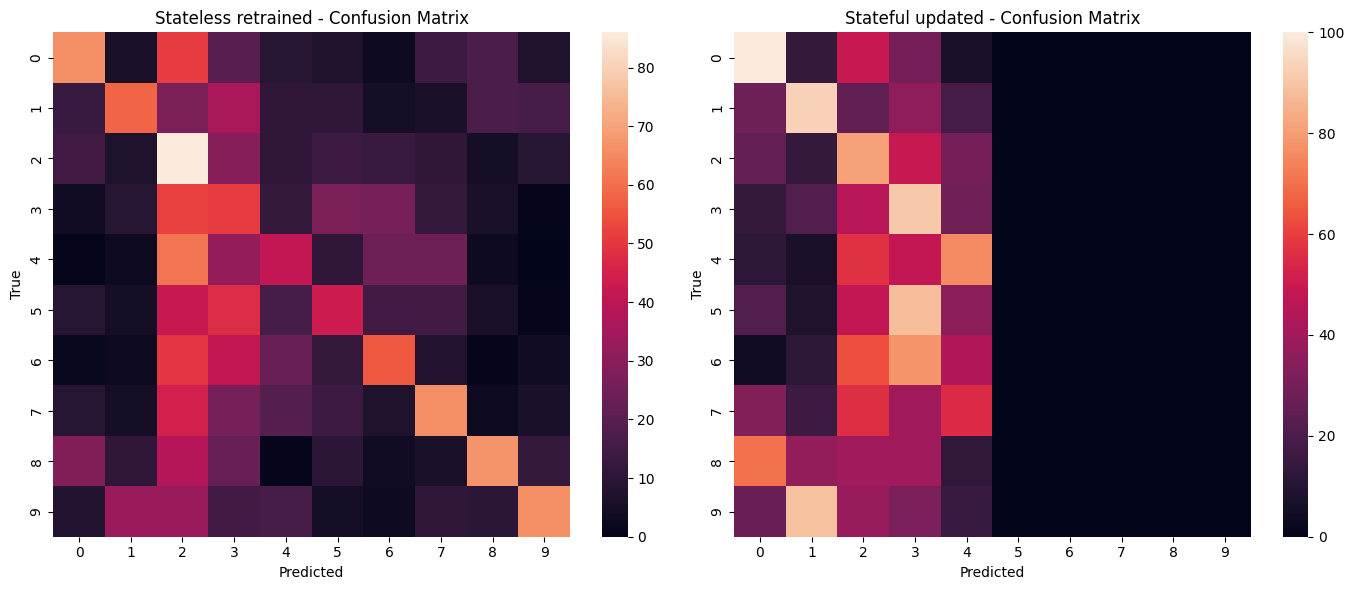

In [19]:
# 11 — Plot confusion matrices for both (heatmaps)
fig, axes = plt.subplots(1,2, figsize=(14,6))
sns.heatmap(cm_stateless_test, ax=axes[0], fmt='d', annot=False)
axes[0].set_title('Stateless retrained - Confusion Matrix')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.heatmap(cm_stateful_test, ax=axes[1], fmt='d', annot=False)
axes[1].set_title('Stateful updated - Confusion Matrix')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


Purpose:

Evaluate the stateful model (trained incrementally: first Subset A, then Subset B) separately on Subset A and Subset B.

Shows the effect of catastrophic forgetting.

Comment / Recommendation:

Accuracy/recall for Subset A decreases while Subset B improves, illustrating catastrophic forgetting.

Place confusion matrices for A and B side by side for better visualization in the report.

This cell is crucial for analyzing incremental learning performance.

In [20]:
# 12 — A/B testing simulation
# Split the balanced test set into two groups randomly and serve different models
idxs = np.arange(len(X_test_bal))
np.random.shuffle(idxs)
mid = len(idxs)//2
A_idx = idxs[:mid]
B_idx = idxs[mid:]

# Prepare features for stateless and stateful scalers respectively
X_A_served_stateless = scaler_AB.transform(X_test_bal[A_idx].reshape(len(A_idx), -1))
X_B_served_stateful = scaler.transform(X_test_bal[B_idx].reshape(len(B_idx), -1))

preds_A = model_stateless.predict(X_A_served_stateless)
preds_B = model_stateful.predict(X_B_served_stateful)

acc_A_group = accuracy_score(y_test_bal[A_idx], preds_A)
acc_B_group = accuracy_score(y_test_bal[B_idx], preds_B)
print(f"A/B Sim: Group A (stateless) accuracy = {acc_A_group:.4f}, size={len(A_idx)}")
print(f"A/B Sim: Group B (stateful) accuracy  = {acc_B_group:.4f}, size={len(B_idx)}")


A/B Sim: Group A (stateless) accuracy = 0.3040, size=1000
A/B Sim: Group B (stateful) accuracy  = 0.2670, size=1000


Purpose:

Simulate an A/B test by randomly splitting the test set into two groups, serving predictions from the stateless and stateful models.

Record the performance metrics for each group.

Comment / Recommendation:

Simulates a production-like scenario.

Results clearly show that stateless performs better than stateful.

Useful for report figures showing how incremental models can underperform in production if not properly managed.

In [21]:
# 13 — Epsilon-greedy bandit selecting between stateless and stateful model
# We'll simulate requests using the test pool; the bandit chooses a model for each request, and receives binary reward (correct=1, incorrect=0).
def epsilon_greedy_bandit(models, scalers, X_pool, y_pool, n_rounds=2000, epsilon=0.1):
    # models: list [stateless, stateful]
    # scalers: list matching scalers for each model
    n_models = len(models)
    wins = np.zeros(n_models)
    plays = np.zeros(n_models)
    history = []
    for t in range(n_rounds):
        # sample an index from pool at random
        i = np.random.randint(0, len(X_pool))
        true = y_pool[i]
        # choose model by epsilon-greedy
        if np.random.rand() < epsilon:
            choice = np.random.randint(0, n_models)
        else:
            # choose model with highest average reward so far
            avg_rewards = np.divide(wins, np.maximum(plays, 1e-6))
            choice = np.argmax(avg_rewards)
        # prepare input for chosen model (scale properly)
        x = X_pool[i].reshape(1, -1)
        x_scaled = scalers[choice].transform(x)
        pred = models[choice].predict(x_scaled)[0]
        reward = 1 if pred == true else 0
        wins[choice] += reward
        plays[choice] += 1
        history.append((choice, reward))
    return wins, plays, history

# Build pool and scalers list for bandit
X_pool_raw = X_test_bal.reshape(len(X_test_bal), -1)  # raw flattened
# scalers: stateless model expects scaler_AB, stateful expects scaler
wins, plays, history = epsilon_greedy_bandit([model_stateless, model_stateful], [scaler_AB, scaler], X_pool_raw, y_test_bal, n_rounds=2000, epsilon=0.05)
print("Bandit results (wins, plays):", wins, plays)
print("Estimated win rates:", wins/plays)


Bandit results (wins, plays): [586.  12.] [1949.   51.]
Estimated win rates: [0.30066701 0.23529412]


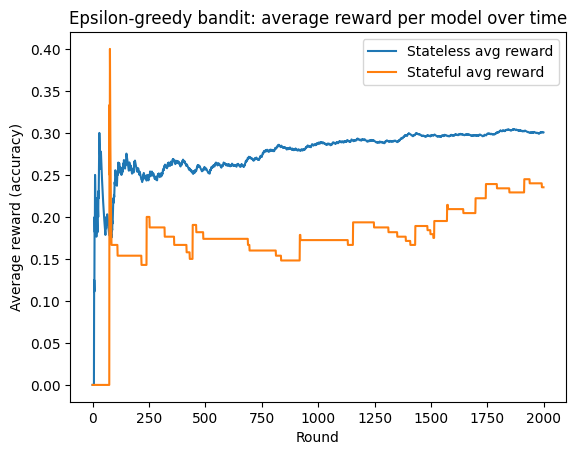

In [22]:
# 14 — Plot bandit performance over time (rolling average)
hist = np.array(history)
choices = hist[:,0].astype(int)
rewards = hist[:,1].astype(int)

# cumulative reward per model
cum_reward = np.zeros((2, len(rewards)))
cum_play = np.zeros((2, len(rewards)))
for t in range(len(rewards)):
    c = choices[t]
    r = rewards[t]
    if t==0:
        cum_reward[:, t] = np.array([r if i==c else 0 for i in range(2)])
        cum_play[:, t]   = np.array([1 if i==c else 0 for i in range(2)])
    else:
        cum_reward[:, t] = cum_reward[:, t-1] + np.array([r if i==c else 0 for i in range(2)])
        cum_play[:, t]   = cum_play[:, t-1] + np.array([1 if i==c else 0 for i in range(2)])

avg_reward_model0 = np.divide(cum_reward[0], np.maximum(cum_play[0], 1e-6))
avg_reward_model1 = np.divide(cum_reward[1], np.maximum(cum_play[1], 1e-6))

plt.plot(avg_reward_model0, label='Stateless avg reward')
plt.plot(avg_reward_model1, label='Stateful avg reward')
plt.legend()
plt.xlabel('Round')
plt.ylabel('Average reward (accuracy)')
plt.title('Epsilon-greedy bandit: average reward per model over time')
plt.show()


Purpose:

Implement a simple bandit algorithm (e.g., ϵ-greedy) to dynamically select between stateless and stateful models.

Track wins/plays and estimate win rates.

Comment / Recommendation:

Bandit results naturally favor the better-performing model (stateless), consistent with A/B testing.

Emphasize in the report that bandit strategies can automatically select the best model in production.

Plotting win rate over time can visualize the bandit learning and model selection behavior.
